# PRÁCTICA 2 - APRENDIZAJE PROFUNDO - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

# JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

# Lab: RNNs for Sentiment Analysis


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook we will deploy RNNs to perform sentiment analysis in a real dataset of finantial news. The required preprocesing using standard NLP libraries will be given to you (you have a course on NLP in the second term to learn this part) and your goal will be to define the RNN model, train it and validate the results.


We will use the [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip), which contains  near 5000 sentences from finantial news:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Lets load the database and preprocess it using [SpaCy](https://spacy.io/). This part is all given to you, so no need to worry much.




A lo largo de la práctica, usaremos RNNs para predecir sentimientos ante un dataset formado por textos. El preprocesado del dataset se asocia a técnicas de NLP (no nos preocuparemos de esta parte de uso de Spacy) y nosotros nos centraremos en definir el modelo RNN.

Tendremos un dataset con 4840 frases relacionadas con el mercado financiero. Buscamos clasificar cada frase en un sentimiento positivo, negativo o neutral respecto al tema que tocan.

Instalamos spacy y el modelo NLP de spacy "en_core_web_lg" (modelo de Spacy en inglés de tamaño grande)

In [1]:
# To use it in colab, update spacy 
!pip install --upgrade spacy 

In [2]:
# Download language model

!python -m spacy download en_core_web_lg

     -------------------                   314.4/587.7 MB 40.9 MB/s eta 0:00:07


2022-11-30 10:44:13.626862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-11-30 10:44:13.627562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
d:\anaconda\envs\ids\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2022-11-30 10:44:46.860277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-11-30 10:44:46.862308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-11-30 10:44:46.864148: W tensorflow/stream_executor/platform/defa

In [125]:
# Importamos las librerías necesarias para el desarrollo de la práctica

import numpy as np
import pandas as pd
import spacy
from torch import nn
from torch import optim
import torch
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt

In [4]:
# Introducimos en "lines" 
 
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In lines, we have a list of sentences and an associted label, separated by the character `@`

Como vemos, lines mete todas las frases del dataset. lines[i] hace referencia a la frase "i" del dataset (metida en forma de string).

In [5]:
lines[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n'

In [6]:
lines[1]

'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .@positive\n'

We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

Separamos en frases y sentimiento usando la @ como separador. Por otro lado, creamos una función que establezca los sentimientos negativos como "1", los positivos como "2" y los neutrales como "0".

In [7]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):
    
    d = 0
    
    if (l=='negative\n'):
        
        d = 1
        
    elif (l=='positive\n'):
        
        d = 2
        
    return d

labels = np.array([code_opinion(l) for l in opinions])
    

En labels contamos con los etiquetas de cada una de las frases:

In [8]:
labels

array([0, 2, 2, ..., 1, 1, 0])

In [9]:
# Introducimos las frases con las etiquetas en un DataFrame

df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


Lets plot the histogram of the labels ...

Veamos el balanceo de clases de nuestro dataset:

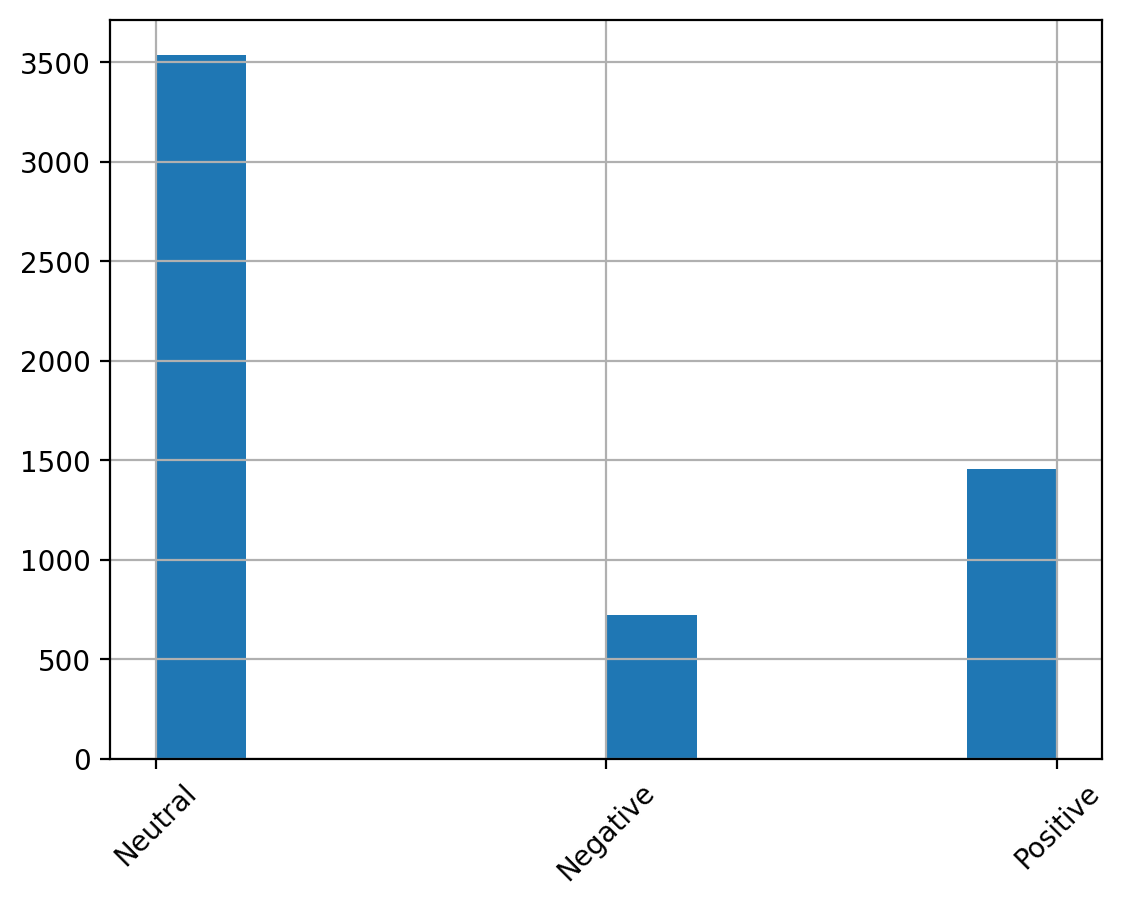

In [10]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


Para simplificar el problema, fusionaremos las etiquetas "Neutral" y "Positive". 1 es Negative y 0 es Positive+Neutral. 
A su vez, dividiremos en conjunto de entrenamiento, validación y test.

To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [11]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0 

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

En entrenamiento, test y val tomamos; las etiquetas tal cual y, los index de las sentences (no cogemos las frases tal cual).

In [12]:
# Ej, frases de validación:
idx_val

array([3869, 2397, 1937, 3742, 4530, 2411, 1173, 1967, 4156, 4200, 1491,
       1103, 1032, 4009,  462, 2020, 2957, 2793, 2155, 3962, 4970, 3854,
       3377, 1738, 2915,  350,  570, 4961, 3461, 1633, 2589, 4503, 3393,
       4581, 1077, 4723, 4722,  324, 1031, 3732,  399, 5634, 4858,  431,
       3446, 4873, 5124,  685, 4278, 4593, 4349,  184,  680, 5460, 3366,
       2771,  937, 4310, 2069, 1561, 4034, 2446, 1908, 1753, 1322, 1306,
       4404, 1923, 4949, 2088, 1794, 4097, 4110, 5597, 2094, 2285, 4506,
       1523, 2514, 4967, 4832, 2003,  744, 2007, 2616, 4638, 2252, 2585,
       2642, 3504, 1917, 4108, 2562, 4255, 4136,  877, 3058, 2276, 2384,
       5556, 2557, 4086, 4551, 3820, 2889, 4265, 5145,  800,  366, 5353,
       1036, 2985,  162, 4624, 2584, 3536, 2419,  730, 1645,   60, 4922,
       2609, 4152, 5499, 3210, 1881,  475,  507, 5574,   78,  501, 1874,
       4165, 3017, 4985, 1562, 3982, 2554, 1187,  216, 3770, 2566, 1767,
       1318, 3087, 5177,  457, 4902,  995, 2521, 14

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks.  As a result, we have the list `norm_docs`. 

Note that are better preprocessing steps that we can take, such as removing [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html). But we leave these ideas to other courses more focused on NLP.

In [13]:
nlp = spacy.load("en_core_web_lg") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) 
def normalize(doc):
    
    return [w for w in doc if w.has_vector and not w.is_punct]

norm_docs = [normalize(d) for d in docs]



d:\anaconda\envs\ids\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_lg' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

El resultado es que, norm_docs es una lista de listas donde cada posición es una lista con los tokens de una frase (eliminando los signos de puntuación). Se pueden realizar muchos más procesos de preprocesado para los tokens (como eliminación de stopwords, n-gramas...) sin embargo eso lo dejaremos para la asignatura de NLP.

In [14]:
print(f'The first original sentence is: {phrases[0]}\n')

print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, to, Gran, the, company, has, no, plans, to, move, all, production, to, Russia, although, that, is, where, the, company, is, growing]. The length of the document is 22 tokens


We can access to the word embedding of each token using the attribute `.vector`:

Cada token tiene su embedding (su representación vectorial en 300 dimensiones) a la que se puede acceder con ".vector":

In [15]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-1.8993e-01  7.0686e-03  2.2466e-01  1.1441e-01 -1.7058e-01 -2.0702e-02
  1.0430e-01  6.1981e-02 -5.4537e-02  2.6813e+00 -2.8966e-01  2.2361e-01
 -2.1493e-02  2.9268e-01 -2.5843e-01 -5.3807e-01  3.3709e-01  1.1680e+00
  1.6551e-01  6.5886e-02  1.4446e-01  3.4677e-01 -1.2809e-01 -3.8114e-02
  2.2085e-01  1.9886e-01 -4.1755e-01  1.6474e-01 -2.2054e-01 -2.7242e-02
  8.8179e-02  2.7589e-01  2.5669e-01  2.1639e-01  1.6127e-01  4.2795e-01
  2.0554e-04 -1.3096e-01  5.1889e-02 -1.1941e-01 -2.0728e-01  6.0784e-02
  1.7197e-01 -2.6056e-02 -2.5960e-01 -2.7028e-01  6.9555e-02 -1.3087e-01
  1.0921e-01 -1.2391e-01 -1.8302e-01 -2.8909e-01 -3.3452e-01 -2.5565e-01
 -2.6496e-01 -2.8909e-01 -5.6848e-02  4.3846e-01  1.4577e-01 -2.0472e-01
  3.2083e-01 -5.1273e-02 -1.8690e-01  3.8355e-01 -3.7892e-01  1.7339e-01
 -3.8200e-01  8.3093e-03  2.6051e-01  3.4202e-01 -1.5279e-01 -3.1518e-01
  2.8419e-01 -3.4394e-01 -4.3389e-01  2.5400e-02  5.4666e-02  2.5

You can check that the word embedding dimension is 300 ...

In [16]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



Cada mini_batch de frases debe tener la misma length (es decir, el mismo número de tokens) por lo que, para no complicarnos, tomaremos como referencia la length de la frase más larga e igualaremos todas en tamaño rellenándolas con "#" (tokens de relleno):

In [17]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [18]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

Recall that for each document, the sequence of word embeddings is obtained using the `.vector` attribute per token ...

En este caso tenemos ya las frases de entrenamiento, test y validación en docs_xxxx y sus etiquetas en y_xxxx.

A su vez, guardamos (tanto para train, validación y test) las longitudes de cada una de sus frases (hasta justo antes de empezar con los tokens de relleno ya que luego, para clasificación, esos no deben usarse).

### RNN classification

Our goal is to implement an LSTM that takes as input the sequence of word embeddings and predicts the binary label. In the list `lengths` we have the length per document (before adding the junk tokens). The LSTM prediction **must be done using the LSTM state after processing the last real token**. That means we ignore the LSTM states after we start processing the junk tokens.


A few comments:

- The LSTM is trained using mini-batches. So the input is a tensor of dimension (batch_size, seq_length, max_l). You have to generate this tensor using the lists implemented before (`docs_train`, `docs_val`, `docs_test`).
- You don't care about the LSTM initializaiton. Use the default one.
- The LSTM provides the list of states upon processing the sequences of max_l word embeddings. For each sentence, you have to predict the label using the appropiate state (the one after processing the last real word). My advise is that you store in a list the decision states for each data in the minibatch and then concatenate them in a tensor using `torch.stack`.
- We will use a single MLP layer to perform the prediction. Between the LSTM and the MLP, we include a dropout layer. 
- The network will take some time to train, so my advise is to save the network parameters after each epoch (in a separate file), so early stopping can be implemented without re-training.
- Validate the dimension of the LSTM state.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />




Utilizaremos una RNN para clasificar. Para ello pasaremos las frases (donde a cada célula le meteremos el embedding de una palabra, por tanto el tamaño del input va a ser de 300) de cada uno de los batches (recordemos que por la presencia de los "tokens de relleno" todas las frases tienen la misma longitud y esos tokens de relleno no se usarán posteriormente, por lo que no habrá problema). Tras ello aplicaremos una capa lineal con dropout (donde entrará un vector de dimensión "hidden_dim" (que es la salida de la RNN) y saldrá un vector de 2 dimensiones indicando si el sentimiento de la frase es Positivo+Neutral o Negativo).

>**Exercise:** Complete the following code to construct the RNN classifier

In [72]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):
        
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        #self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers=n_layers, 
        #                  nonlinearity='relu',batch_first=True) #YOUR CODE HERE

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, # La diferencia con la RNN es precisamente esta, introducimos la red LSTM en este fragmento de código.
                            dropout=prob, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) 
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Capa dropout 
        
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        
        '''
        
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify

        '''
        
        batch_size = x.size(0) 
        seq_length = x.size(1) 
        
        # Compute the RNN output (sequence of states for the whole input)
        #r_out, _ =  self.rnn(x,h0)
        r_out, _ =  self.lstm(x,h0)
        
        # Now it comes the tricky part. You have to stack in a (batch_size, hidden_dim) tensor, the right state
        # for each sequece. Namely, the state after processing the last real token (not the junk # ones)
        # The function torch.stack() can be handy
        
        aux = torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim]) #YOUR CODE HERE (2nd dim r_out)
        
        # We classify using such tensor (don't forget the dropout!)
        
        output = self.logsoftmax(self.dropout(self.fc1(aux))) # La salida es la logsoftmax de la capa lineal a la que se le aplica dropout y tiene como entrada la salida de la RNN
    
        
        return output

Let's first illustrate how we can get the output of the (untrained) RNN network given our texts. For example, let's get the RNN output for the first three training texts. The first step is to get the **sequences of word embeddings** of each of them...

In [73]:
idx = [1,2,3]

#[w.vector for w in docs_train[d]] generates the list of word vectors for the d-th document 
x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])

In [74]:
d=1

np.array([docs_train[d][w].vector for w in range(len_train[d])]).shape

(21, 300)

In [75]:
aux = torch.Tensor([np.mean([docs_train[d][w].vector for w in range(len_train[d])],0) for d in idx])

The shape of `x_input` should be (3,max_l,300)

In [76]:
x_input.shape

torch.Size([3, 52, 300])

Si introducimos solo los 3 primeros textos, viendo el x_input, obtenemos una matriz de: 3 (nº de textos), 52 (tamaño de cada frase con los "tokens de relleno"), 300 (tamaño del vector embedding de cada token de cada frase)

Let's instantiate the RNN class

In [77]:
my_RNN = RNN(300,2,20,1)

d:\anaconda\envs\ids\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


> **Exercise:** evaluate the RNN otuput for `x_input` and check that the ouput dimensions make sense

In [78]:
o = my_RNN.forward(x_input,[lengths[d] for d in idx])

In [79]:
print(o)

tensor([[-0.4283, -1.0545],
        [-0.4195, -1.0711],
        [-0.2346, -1.5649]], grad_fn=<LogSoftmaxBackward0>)


In [80]:
o.shape

torch.Size([3, 2])

Obtenemos para cada uno de las 3 frases sus dos probabilidades asociadas (obviamente el resultado no tiene mucho sentido ya que la RN está sin entrenar).

Introduzcamos un método de entrenamiento a la red e incluyamos un "save" del modelo en cada época con el fin de obtener el mejor al final del propio entrenamiento.

> **Exercise:** Complete the following class, which inherits the previous one and it adds a training loop, an evaluation method, and functionalities to save the model every few epochs

In [81]:
class RNN_with_train(RNN):
    
    #def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):
    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Aprendizaje Profundo/Practica2/RNN_sentiment_analysis'):   # Ruta for colab
        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files
        
        
    def predict_proba(self,docs,lengths,Y=None):
        
        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.
        
        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0
        
        with torch.no_grad(): 
        
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
        
            logprobs = self.forward(x_input,lengths).detach().numpy() #YOUR CODE HERE (forward 2nd argument)
            
            if(len(Y)>0):
            
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
        
    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        
        '''
        Método de entrenamiento.
        
        - docs_train, docs_val: training/validation documents (each is a list of spacy tokens). 
          Normalized in length!
        - len_train/len_val: real lengths
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = len(docs_train) # Number of training points
        
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        
        self.num_val = len(docs_val) # Number of validation points
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numer of validation batches
        
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Activate dropout
            
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  

                # Indices of the data entering the batch
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # We code each document using the sequences of word embeddings
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch]) #YOUR CODE HERE (last word)
                
                # We compute the classifier output for every data
                out = self.forward(x_input,[len_train[d] for d in idx_batch]) #YOUR  CODE HERE (arg of len_train)
                
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                
                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
                # SGD steps
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We save model parameters
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
            # We repeat for validation
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch]) #YOUR  CODE HERE (arg of Tensor)

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

> **Exercise:** Instantiate and train the class using a hidden state of 20 dimensions and dropout probability equal to 0.3. Train for 40 epochs (can take a while)

Entrenamos la red LSTM por 40 épocas con los parámetros indicados:

In [82]:
my_RNN = RNN_with_train(input_size = 300, output_size = 2, hidden_dim = 20, n_layers = 1,  prob = 0.3, batch_size = 50, lr=0.0005)

#Call train

my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)


d:\anaconda\envs\ids\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training loss after 0 epochs: 0.5943044460799596. Validation loss: 0.40809737477037644
Training loss after 1 epochs: 0.4092904439527694. Validation loss: 0.3216557850440343
Training loss after 2 epochs: 0.3722492666685418. Validation loss: 0.28524430344502133
Training loss after 3 epochs: 0.34473201591674596. Validation loss: 0.2718380300535096
Training loss after 4 epochs: 0.33013354731749184. Validation loss: 0.2616184643573231
Training loss after 5 epochs: 0.30828764197761066. Validation loss: 0.24883609430657494
Training loss after 6 epochs: 0.2717822645216772. Validation loss: 0.2281247518128819
Training loss after 7 epochs: 0.25816244111485676. Validation loss: 0.21967439477642378
Training loss after 8 epochs: 0.23740054115857165. Validation loss: 0.2050164942112234
Training loss after 9 epochs: 0.21097814567285042. Validation loss: 0.1876981556415558
Training loss after 10 epochs: 0.20101101216796327. Validation loss: 0.18108112406399515
Training loss after 11 epochs: 0.18361099

> **Exercise:** Plot both validation and training loss. Recover the model parameters for the epoch that minimized the validation loss. To do so, note that at every epoch the model parameters are save in a certain file named  `RNN_sentiment_analysis_epoch_X.pth` (unless you changed the default value), where `X` is the epoch. The function to re-state the parameters of the network are  `state_dict = my_RNN.load_state_dict(torch.load('RNN_sentiment_analysis_epoch_X.pth'))
`

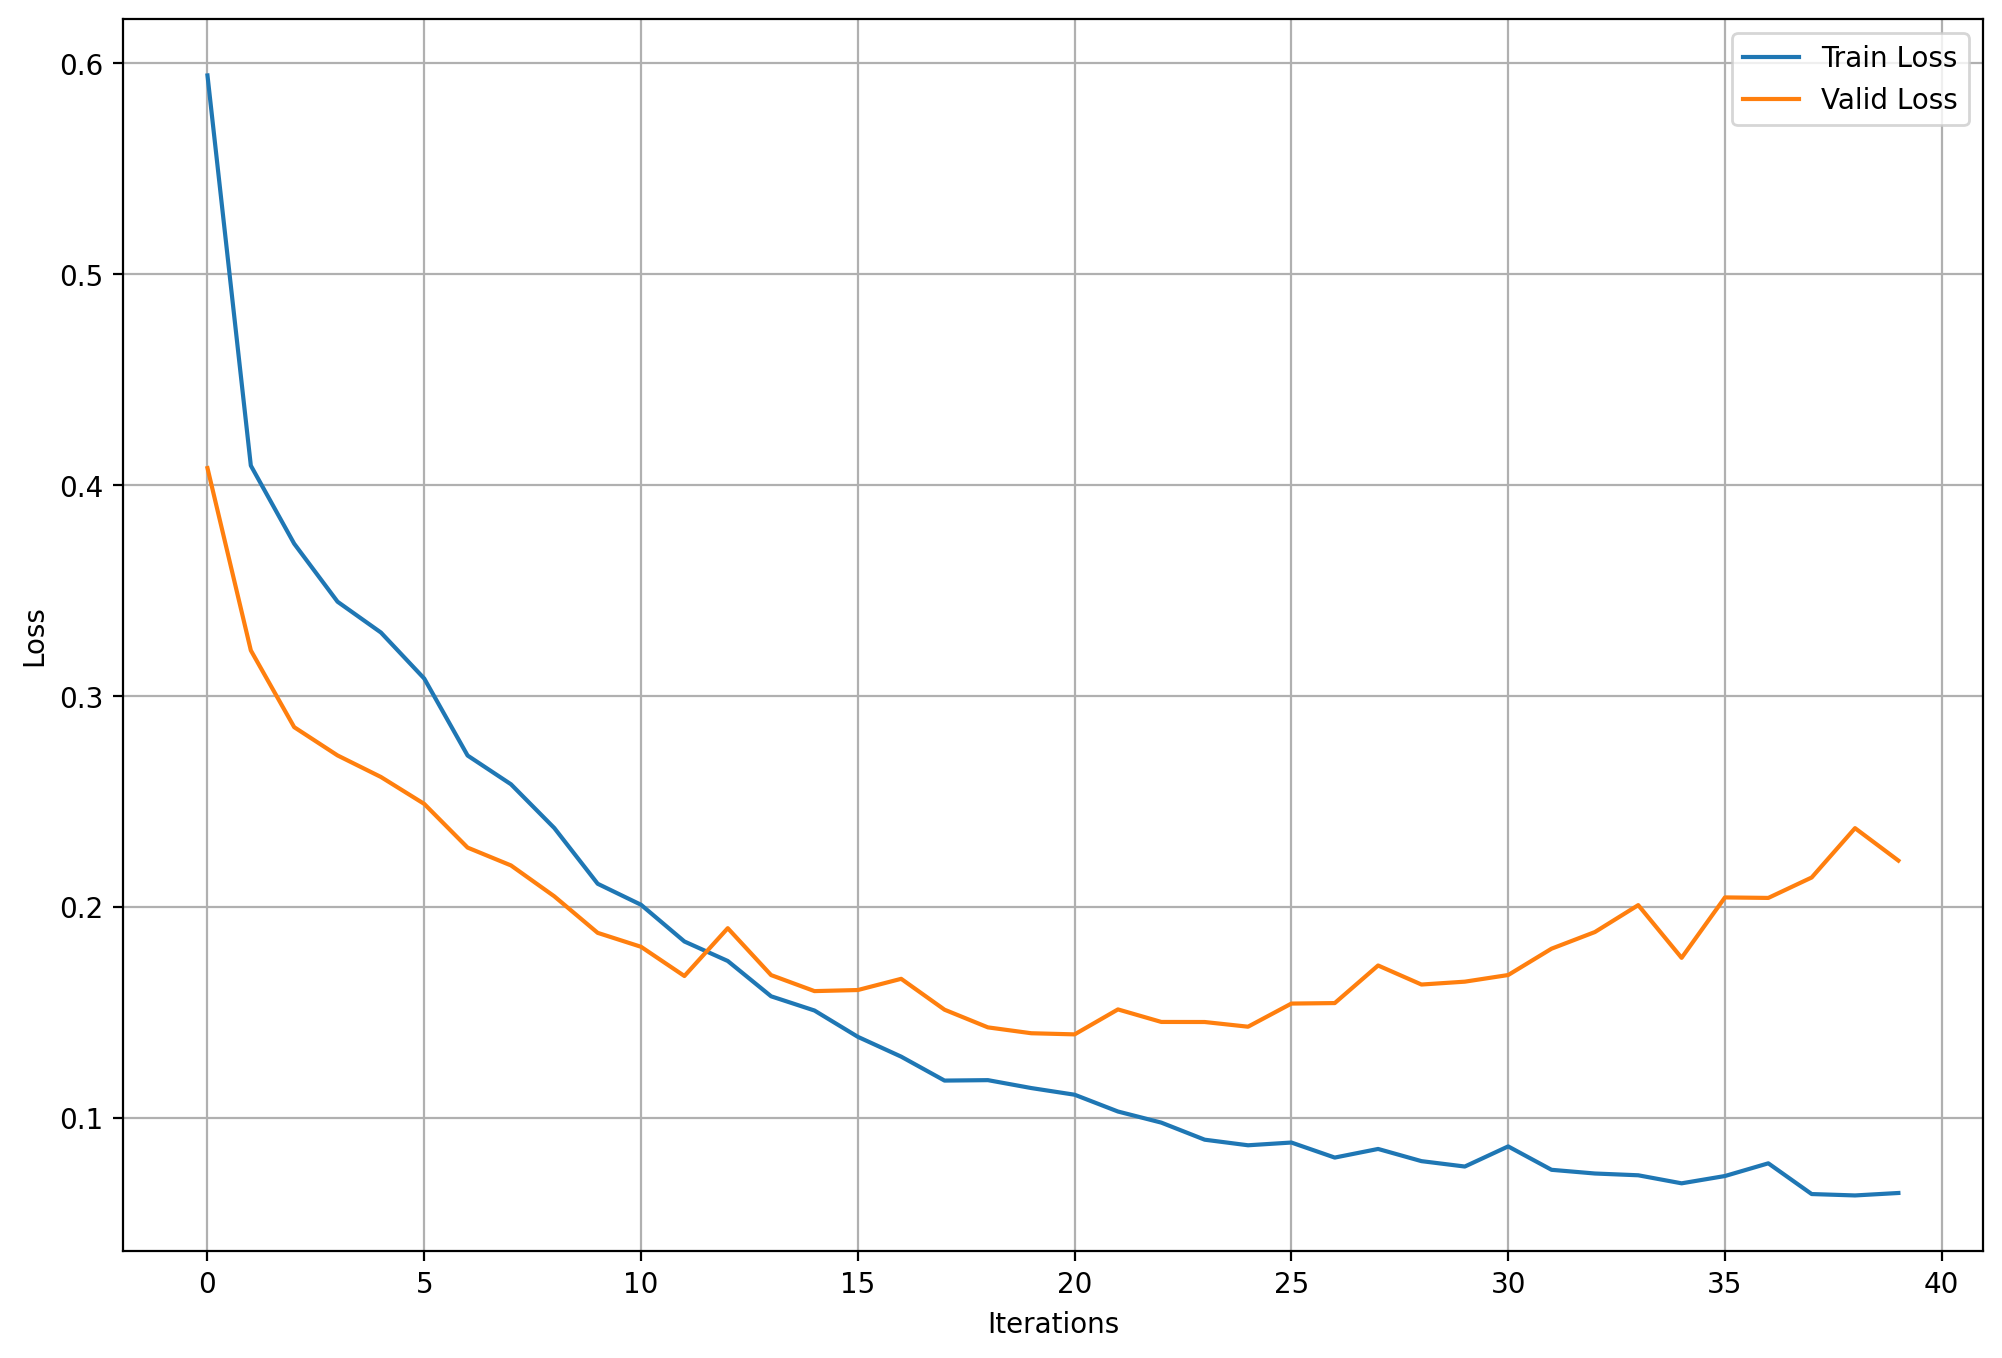

In [83]:
# Plotting the train/val loss

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(my_RNN.loss_during_training, label='Train Loss')
ax.plot(my_RNN.valid_loss_during_training, label='Valid Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend()
ax.grid()

Como vemos, los resultados son realmente buenos. Gracias a aplicar "dropout" el overfitting comienza ciertamente más tarde de lo normal, sin embargo, podemos ver el efecto del mismo a partir de, aproximadamente, la época 20 (vemos como la pérdida de validación empieza a aumentar mientras que la de entrenamiento disminuye dando a entender que en este punto, el modelo se ha adaptado y memorizado los datos de entrenamiento). Por ello, aplicaremos "early stopping" cargando el modelo con mejor "loss validation":

Cargamos el mejor modelo obtenido a lo largo del entrenamiento (el que mejor valid_loss proporcione).

In [84]:
# Recovering the best validation parameters

idx_min = np.argsort(my_RNN.valid_loss_during_training)

my_RNN.load_state_dict(torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

> **Exercise:** Using the method `predict_proba`, compute the accuracy and class probabilities for the data in the test set. Note that the method returns log-probabilities that you have to exponentiate.

Veamos el accuracy obtenido dado el modelo:

In [85]:
logprobs,acc = my_RNN.predict_proba(docs_test,len_test,y_test)
probs = np.exp(logprobs)  #YOUR CODE HERE

print(f"The test accuracy is {acc}")

The test accuracy is 0.951048951048951


Como vemos, el resultado (aplicando dropout, early stopping y una LSTM) es realmente bueno. Al final es un problema sencillo que con un word embedding es "relativamente" fácil de predecir. El resultado se ve reflejado en el propio accuracy.

The following code plots the ROC curve of the classifiers, and it computes the area under the curve:

C:\Users\José\AppData\Local\Temp\ipykernel_15148\2390240904.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


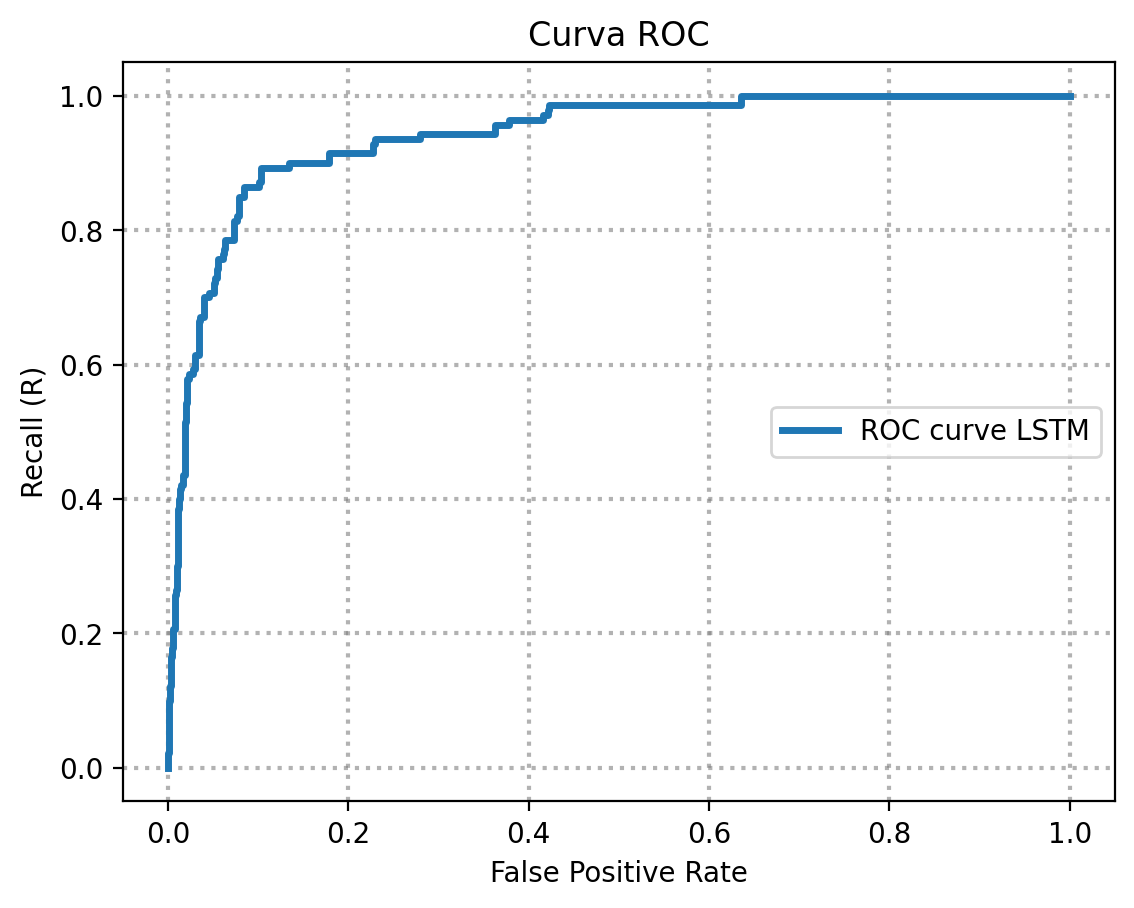

AUC ROC for LSTM is 0.9400611838360842


In [34]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

El resultado exitoso también se aprecia en la curva ROC. Dada la información que proporciona, el resultado se aproxima bastante a una curva ROC "ideal".

### (OPTIONAL FOR AND ADDITIONAL 0.5 GRADE) 

Compare the accuracy/ROC with those achieved by the MLP classifier that predicts the label using the **mean of the word embeddings** (without junk tokens). Consider a three layer MLP with 10 and 5 hidden units respectively.


<img src='http://www.tsc.uc3m.es/~olmos/BBVA/MLP.png' width=800 />

Cargamos un MLP con 3 capas. La entrada con 300 unidades (que será la media de los embeddings de los tokens de la frase que no sean "tokens de relleno") y las otras con 10, 5 y una salida de 2 (las probabilidades). Aplicamos dropout (para mejorar el resultado) y una función de activación "ReLu":

In [37]:
# Añadimos la ténica de dropout

class MLPdrop(nn.Module):
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,p_dropout): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,nlabels)
        
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)

        self.dropout = nn.Dropout(p=p_dropout)   # Introducimos la posibilidad del dropout                                                       
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x) # Tras cada salida, introducimos el dropout
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.logsoftmax(x)
        return x

Creamos y modificamos la clase para entrenar el MLP dada la naturaleza y los datos del problema:

In [38]:
# Entrenamiento, validación y acuraccy junto al dropout

class MLPdrop_extended(MLPdrop):
    # Todo es igual que el regresor logístico multiclase pero añadiendo el número de las neuronas de las capas ocultas
    # Añadimos la dimensión de la capa extra con la que contamos
    def __init__(self,dimx,hidden1,hidden2,nlabels,batch_size,p_dropout,epochs=100,lr=0.001,saved_files='C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Aprendizaje Profundo/Practica2/MLP_sentiment_analysis'):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,p_dropout)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate

        self.saved_files = saved_files

        self.batch_size = batch_size
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def fit(self,docs_train,docs_val,Y,Yval,epochs=40,print_every=5):
        
        '''
        Método de entrenamiento.
        
        - docs_train, docs_val: training/validation documents (each is a list of spacy tokens). 
          Normalized in length!
        - len_train/len_val: real lengths
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = len(docs_train) # Number of training points
        
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        
        self.num_val = len(docs_val) # Number of validation points
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numer of validation batches
        
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Activate dropout
            
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  

                # Indices of the data entering the batch
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # We code each document using the sequences of word embeddings
                x_input = torch.tensor([docs_train[i] for i in idx_batch])
                
                # We compute the classifier output for every data
                out = self.forward(x_input) #YOUR  CODE HERE (arg of len_train)
                
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                
                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
                # SGD steps
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We save model parameters
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
            # We repeat for validation
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)
                

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    x_input = torch.tensor([docs_val[i] for i in idx_batch])

                    out = self.forward(x_input)

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")


Dada la clase creada, creamos (para entrenamiento, validación y test) un dataset que se forme con listas donde en cada posición tenemos el sentence embedding de cada frase (el sentence embedding se hace con la media de los word embedding de cada token de la frase que no sea un token de relleno "#"):

In [39]:
train_embeddings = []

for i in range (len(docs_train)):
    total_embd = 0
    for j in range (len_train[i]):
        embedding_vector = docs_train[i][j].vector 
        total_embd = total_embd + embedding_vector
    doc_embd = total_embd / (len_train[i])
    train_embeddings.append(doc_embd)

In [40]:
validation_embeddings = []

for i in range (len(docs_val)):
    total_embd = 0
    for j in range (len_val[i]):
        embedding_vector = docs_val[i][j].vector 
        total_embd = total_embd + embedding_vector
    doc_embd = total_embd / (len_val[i])
    validation_embeddings.append(doc_embd)

In [41]:
test_embeddings = []

for i in range (len(docs_test)):
    total_embd = 0
    for j in range (len_test[i]):
        embedding_vector = docs_test[i][j].vector 
        total_embd = total_embd + embedding_vector
    doc_embd = total_embd / (len_test[i])
    test_embeddings.append(doc_embd)

Creamos el MLP y lo entrenamos por 40 épocas (así comparamos directamente con la LSTM):

In [86]:
my_MLP_NLP = MLPdrop_extended(dimx=300,hidden1=10,hidden2=5,nlabels=2,epochs=40,lr=1e-3, p_dropout=0.3, batch_size=50)
my_MLP_NLP.fit(docs_train=train_embeddings, docs_val=validation_embeddings,Y=y_train,Yval=y_val)

Training loss after 0 epochs: 0.5997759234415342. Validation loss: 0.5612008836534288
Training loss after 5 epochs: 0.31762187407441334. Validation loss: 0.2639389865928226
Training loss after 10 epochs: 0.27207136194999904. Validation loss: 0.24278888520267275
Training loss after 15 epochs: 0.24316117687992853. Validation loss: 0.21945157191819614
Training loss after 20 epochs: 0.22169195146185078. Validation loss: 0.21663345727655622
Training loss after 25 epochs: 0.20817784036267295. Validation loss: 0.20450143267711005
Training loss after 30 epochs: 0.19503518408291962. Validation loss: 0.1970740912689103
Training loss after 35 epochs: 0.18874107944230512. Validation loss: 0.19506691272060075


Ploteemos su función de entrenamiento vs validación:

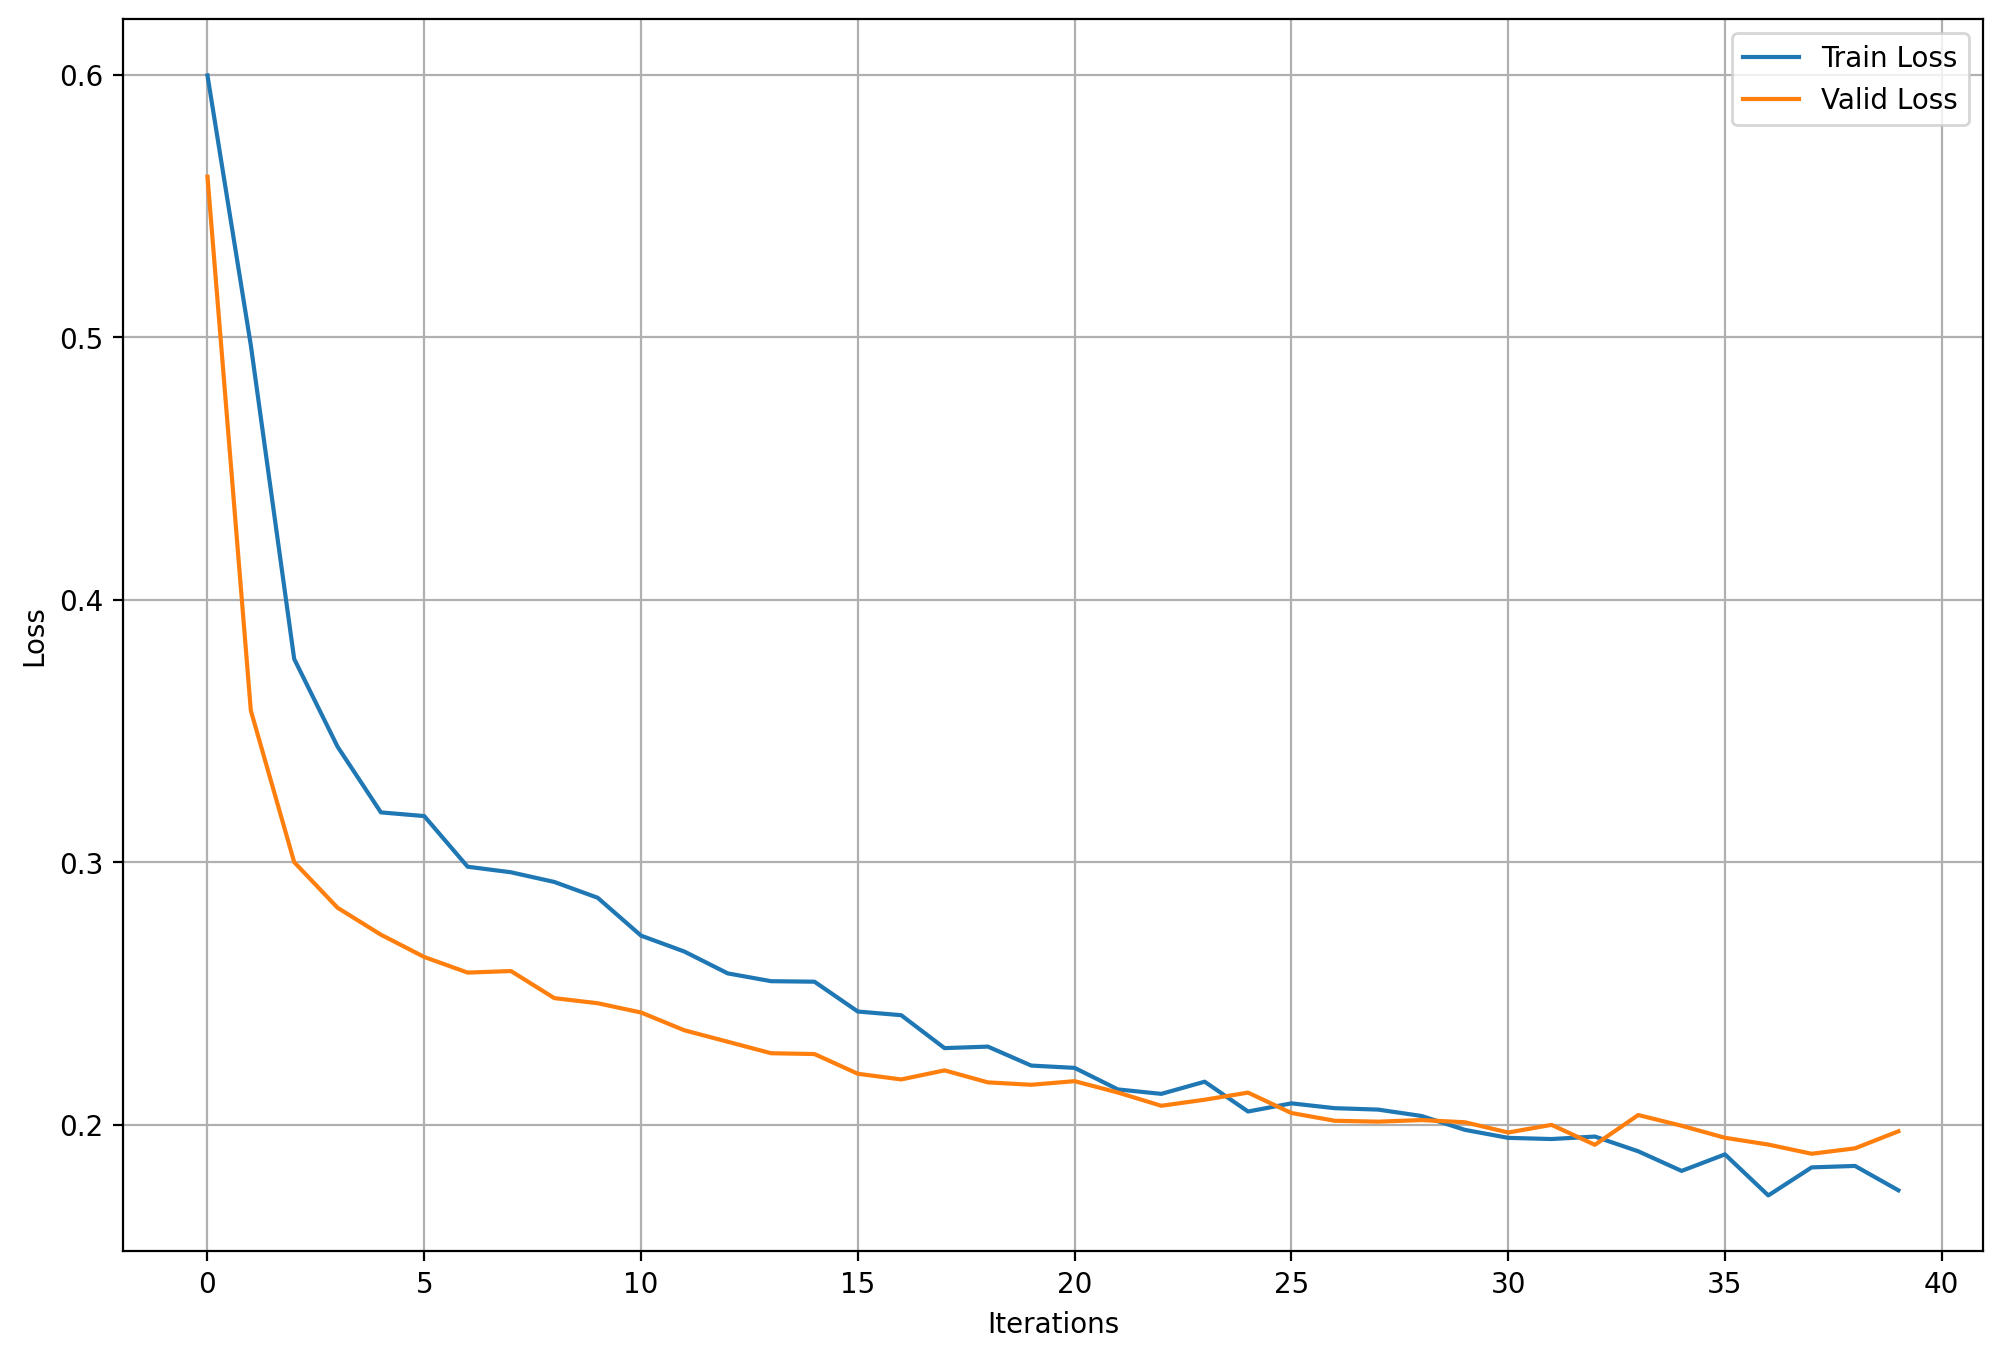

In [87]:
# Plotting the train/val loss

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(my_MLP_NLP.loss_during_training, label='Train Loss')
ax.plot(my_MLP_NLP.valid_loss_during_training, label='Valid Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend()
ax.grid()

Como vemos, un MLP sencillo también proporciona buenos resultados. Con eso confirmamos que el sentence embedding aplicado es una buena solución para representar vectorialmente un conjunto de tokens que conforman una frase. Vemos como no llega (aunque sea por poco) a los mejores resultados en 40 épocas de LSTM pero, gracias al dropout en cada capa y las funciones de activación usadas, en dichas épocas apenas comienza a empezar el overfitting (comeinza algo más tarde, lo cual es bueno).

Cargamos el mejor modelo MLP obtenido en función de la época con la validation loss más pequeña:

In [88]:
# Recovering the best validation parameters

idx_min = np.argsort(my_MLP_NLP.valid_loss_during_training)

my_MLP_NLP.load_state_dict(torch.load(my_MLP_NLP.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

Ajustamos los datos de test para obtener el accuracy:

In [89]:
x = torch.tensor(test_embeddings)
y_pred = my_MLP_NLP.forward(x)
y_pred_numpy = y_pred.detach().numpy()

pos = []

for i in range (len(y_pred_numpy)):
    pos.append(y_pred_numpy[i].argmax())

Obtenemos el accuracy dado el modelo MLP:

In [124]:
accuracy_score(y_test, pos)

0.9213286713286714

Es sutilmente peor que los resultados de LSTM (que llegan a un 95% de accuracy) pero, no solo el resultado es realmente bueno, sino que es computacionalmente muy óptimo (mientras que 40 épocas de LSTM tardan unos 5 minutos en ejecutarse, con el MLP apenas llega a los 10 segundos). Con esto concluimos en una valoración positiva para el MLP utilizado en este tipo de problemas.